Best thresholds: Red > 0.5, Blue > 0.5, Green between 0.2 and 0.5
Minimum color distance to target pinkish hue: 0.07114979123426943


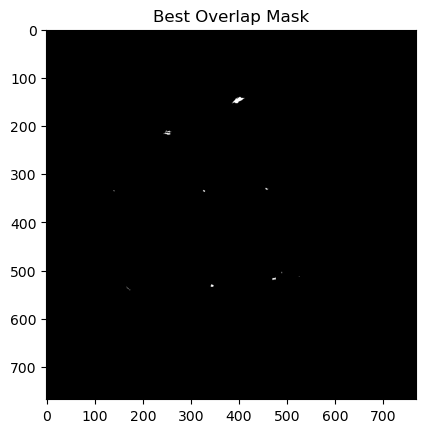

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Function to compute overlap mask based on thresholds
def compute_overlap_mask(img, red_thresh, blue_thresh, green_thresh_min, green_thresh_max):
    R = img[:, :, 0]
    G = img[:, :, 1]
    B = img[:, :, 2]
    
    # Generate overlap mask based on expanded green threshold range
    overlap_mask = (R > red_thresh) & (B > blue_thresh) & (G > green_thresh_min) & (G < green_thresh_max)
    return overlap_mask

# Function to calculate color distance to target pinkish RGB
def color_distance(mask, img, target_rgb=(0.75, 0.4, 0.75)):
    overlap_pixels = img[mask]  # Get pixels within overlap mask
    if len(overlap_pixels) == 0:  # Avoid empty overlap mask
        return np.inf
    avg_color = overlap_pixels.mean(axis=0)  # Average color in overlap region
    distance = np.sqrt(np.sum((avg_color - target_rgb) ** 2))  # Euclidean distance
    return distance

# Load the segmented image
segmented_image_path = '/Users/chunduri/Desktop/CVD Project/Datasets/Aditya/Data/Segmented_Images/10.png'
segmented_image = mpimg.imread(segmented_image_path)

# Define threshold ranges for brute-force search with a wider range for green channel
red_thresholds = np.arange(0.4, 0.8, 0.1)
blue_thresholds = np.arange(0.4, 0.8, 0.1)
green_thresholds_min = np.arange(0.2, 0.4, 0.1)
green_thresholds_max = np.arange(0.5, 0.7, 0.1)

best_combination = None
min_color_distance = np.inf

# Brute-force search for the best threshold combination
for red_thresh in red_thresholds:
    for blue_thresh in blue_thresholds:
        for green_thresh_min in green_thresholds_min:
            for green_thresh_max in green_thresholds_max:
                if green_thresh_min >= green_thresh_max:
                    continue  # Ensure valid green range

                overlap_mask = compute_overlap_mask(segmented_image, red_thresh, blue_thresh, green_thresh_min, green_thresh_max)
                color_dist = color_distance(overlap_mask, segmented_image, target_rgb=(0.75, 0.4, 0.75))

                # Update best combination if current one has smaller color distance
                if color_dist < min_color_distance:
                    min_color_distance = color_dist
                    best_combination = (red_thresh, blue_thresh, green_thresh_min, green_thresh_max)

# Display results
print(f"Best thresholds: Red > {best_combination[0]}, Blue > {best_combination[1]}, Green between {best_combination[2]} and {best_combination[3]}")
print(f"Minimum color distance to target pinkish hue: {min_color_distance}")

# Visualize the best overlap mask
best_overlap_mask = compute_overlap_mask(segmented_image, *best_combination)
plt.imshow(best_overlap_mask, cmap='gray')
plt.title("Best Overlap Mask")
plt.show()


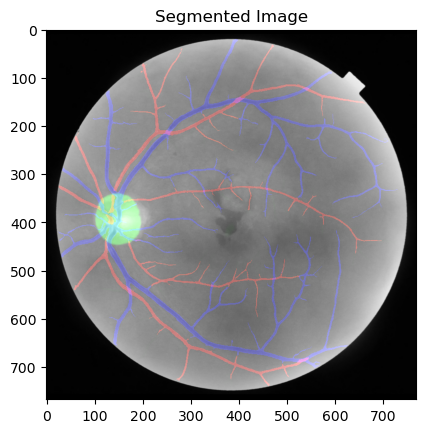

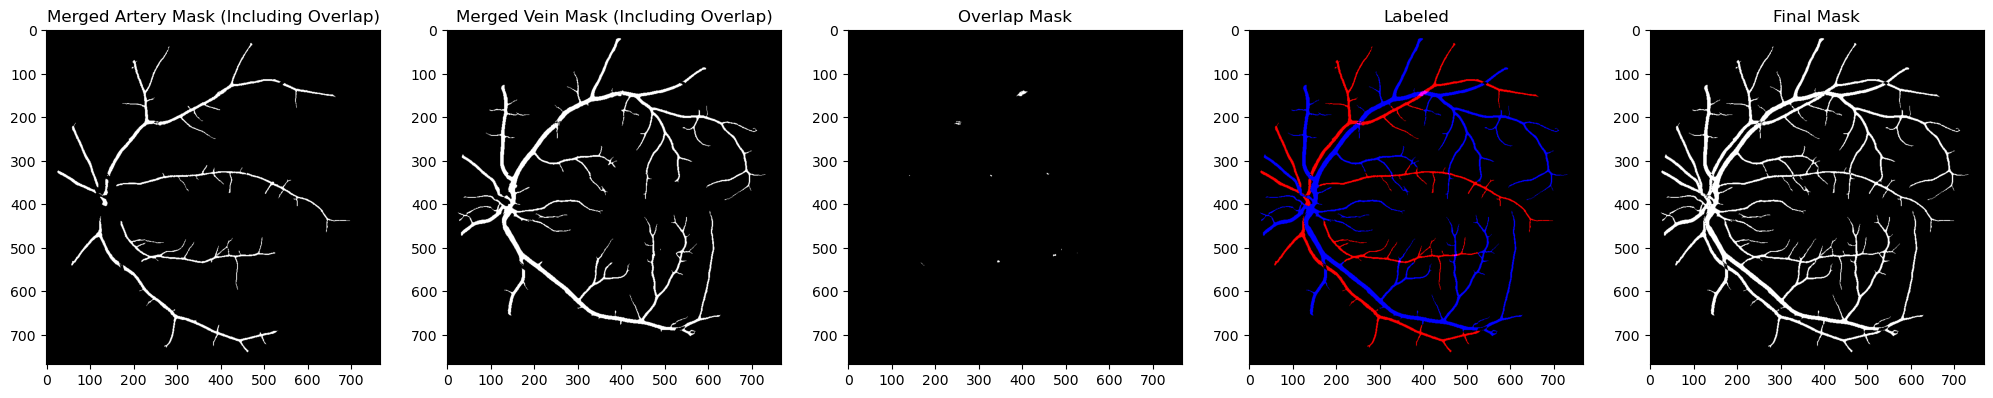

In [7]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg

def extract_AV_overlap_masks(img, red_thresh=0.5, blue_thresh=0.5, green_thresh_min=0.2, green_thresh_max=0.5):
    R = img[:, :, 0]  
    G = img[:, :, 1]  
    B = img[:, :, 2]  

    diff = R - B
    artery_mask = diff > 0.1
    vein_mask = diff < -0.1

    overlap_mask = (R > red_thresh) & (B > blue_thresh) & (G > green_thresh_min) & (G < green_thresh_max)

    merged_artery_mask = np.logical_or(artery_mask, overlap_mask)  
    merged_vein_mask = np.logical_or(vein_mask, overlap_mask)      

    height, width = artery_mask.shape
    av_mask = np.zeros((height, width, 3), dtype=np.float32)
    av_mask[merged_artery_mask, 0] = 1  
    av_mask[merged_vein_mask, 2] = 1    

    bw_mask = np.logical_or(merged_artery_mask, merged_vein_mask).astype(np.float32)

    return merged_artery_mask, merged_vein_mask, overlap_mask, av_mask, bw_mask

segmented_image_path = '/Users/chunduri/Desktop/CVD Project/Datasets/Aditya/Data/Segmented_Images/10.png'
segmented_image = mpimg.imread(segmented_image_path)

plt.imshow(segmented_image)
plt.title("Segmented Image")
plt.show()

merged_artery_mask, merged_vein_mask, overlap_mask, av_mask, bw_mask = extract_AV_overlap_masks(
    segmented_image, 
    red_thresh=0.5, 
    blue_thresh=0.5, 
    green_thresh_min=0.2, 
    green_thresh_max=0.5
)

fig, ax = plt.subplots(1, 5, figsize=(25, 5))
ax[0].imshow(merged_artery_mask, cmap='gray')
ax[0].set_title('Merged Artery Mask (Including Overlap)')
ax[1].imshow(merged_vein_mask, cmap='gray')
ax[1].set_title('Merged Vein Mask (Including Overlap)')
ax[2].imshow(overlap_mask, cmap='gray')
ax[2].set_title('Overlap Mask')
ax[3].imshow(av_mask)
ax[3].set_title('Labeled')
ax[4].imshow(bw_mask, cmap='gray')
ax[4].set_title('Final Mask')
plt.show()

Best thresholds: Red between 0.5 and 0.75, Blue between 0.5 and 0.75, Green < 0.44999999999999996
Minimum color distance to target pinkish hue: 0.05062753884426377


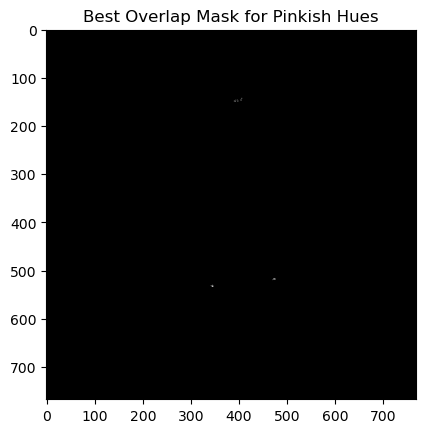

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Function to compute overlap mask based on extended thresholds for pinkish range
def compute_overlap_mask(img, red_thresh_min, red_thresh_max, blue_thresh_min, blue_thresh_max, green_thresh_max):
    R = img[:, :, 0]
    G = img[:, :, 1]
    B = img[:, :, 2]
    
    # Generate overlap mask to capture pink hues with broad red and blue but limited green
    overlap_mask = (R > red_thresh_min) & (R < red_thresh_max) & \
                   (B > blue_thresh_min) & (B < blue_thresh_max) & \
                   (G < green_thresh_max)
    return overlap_mask

# Function to calculate color distance to target pinkish RGB
def color_distance(mask, img, target_rgb=(0.75, 0.4, 0.75)):
    overlap_pixels = img[mask]  # Get pixels within overlap mask
    if len(overlap_pixels) == 0:  # Avoid empty overlap mask
        return np.inf
    avg_color = overlap_pixels.mean(axis=0)  # Average color in overlap region
    distance = np.sqrt(np.sum((avg_color - target_rgb) ** 2))  # Euclidean distance
    return distance

# Load the segmented image
segmented_image_path = '/Users/chunduri/Desktop/CVD Project/Datasets/Aditya/Data/Segmented_Images/10.png'
segmented_image = mpimg.imread(segmented_image_path)

# Define threshold ranges for brute-force search with wider red and blue ranges and a narrow green limit
red_thresholds_min = np.arange(0.5, 0.7, 0.05)
red_thresholds_max = np.arange(0.7, 0.9, 0.05)
blue_thresholds_min = np.arange(0.5, 0.7, 0.05)
blue_thresholds_max = np.arange(0.7, 0.9, 0.05)
green_thresholds_max = np.arange(0.3, 0.5, 0.05)

best_combination = None
min_color_distance = np.inf

# Brute-force search for the best threshold combination
for red_thresh_min in red_thresholds_min:
    for red_thresh_max in red_thresholds_max:
        for blue_thresh_min in blue_thresholds_min:
            for blue_thresh_max in blue_thresholds_max:
                for green_thresh_max in green_thresholds_max:
                    overlap_mask = compute_overlap_mask(segmented_image, red_thresh_min, red_thresh_max, blue_thresh_min, blue_thresh_max, green_thresh_max)
                    color_dist = color_distance(overlap_mask, segmented_image, target_rgb=(0.75, 0.4, 0.75))

                    # Update best combination if current one has smaller color distance
                    if color_dist < min_color_distance:
                        min_color_distance = color_dist
                        best_combination = (red_thresh_min, red_thresh_max, blue_thresh_min, blue_thresh_max, green_thresh_max)

# Display results
print(f"Best thresholds: Red between {best_combination[0]} and {best_combination[1]}, "
      f"Blue between {best_combination[2]} and {best_combination[3]}, Green < {best_combination[4]}")
print(f"Minimum color distance to target pinkish hue: {min_color_distance}")

# Visualize the best overlap mask
best_overlap_mask = compute_overlap_mask(segmented_image, *best_combination)
plt.imshow(best_overlap_mask, cmap='gray')
plt.title("Best Overlap Mask for Pinkish Hues")
plt.show()


Best HSV thresholds: Hue between 140 and 150, Saturation > 50, Value between 100 and 255
Minimum color distance to target pinkish hue: 0.16488907917613255


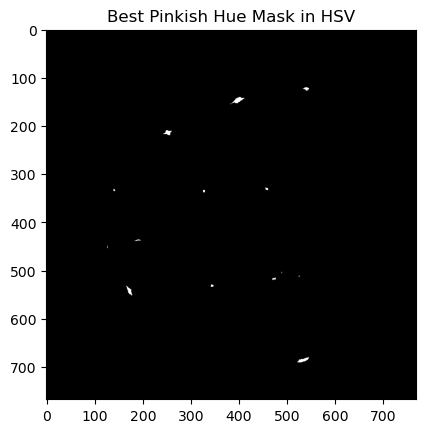

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

# Function to convert image to HSV and create a mask for pinkish hues
def compute_pinkish_mask_hsv(img, hue_min, hue_max, sat_min, val_min, val_max):
    hsv_img = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2HSV)
    # Define range for pinkish color in HSV space
    lower_bound = np.array([hue_min, sat_min, val_min])
    upper_bound = np.array([hue_max, 255, val_max])
    pinkish_mask = cv2.inRange(hsv_img, lower_bound, upper_bound)
    return pinkish_mask > 0

# Brute-force search for the best HSV range
segmented_image_path = '/Users/chunduri/Desktop/CVD Project/Datasets/Aditya/Data/Segmented_Images/10.png'
segmented_image = mpimg.imread(segmented_image_path)

# Define HSV ranges for brute-force search to capture pink hues
hue_ranges = np.arange(140, 180, 5)  # Pinkish hues in HSV usually fall in this range
saturation_min = 50
value_min = 100
value_max = 255

best_hue_min = None
best_hue_max = None
min_color_distance = np.inf

for hue_min in hue_ranges:
    for hue_max in hue_ranges:
        if hue_min >= hue_max:
            continue
        pinkish_mask = compute_pinkish_mask_hsv(segmented_image, hue_min, hue_max, saturation_min, value_min, value_max)
        color_dist = color_distance(pinkish_mask, segmented_image, target_rgb=(0.75, 0.4, 0.75))
        
        # Update best combination if current one has smaller color distance
        if color_dist < min_color_distance:
            min_color_distance = color_dist
            best_hue_min, best_hue_max = hue_min, hue_max

print(f"Best HSV thresholds: Hue between {best_hue_min} and {best_hue_max}, "
      f"Saturation > {saturation_min}, Value between {value_min} and {value_max}")
print(f"Minimum color distance to target pinkish hue: {min_color_distance}")

# Visualize the best overlap mask in HSV
best_pinkish_mask = compute_pinkish_mask_hsv(segmented_image, best_hue_min, best_hue_max, saturation_min, value_min, value_max)
plt.imshow(best_pinkish_mask, cmap='gray')
plt.title("Best Pinkish Hue Mask in HSV")
plt.show()


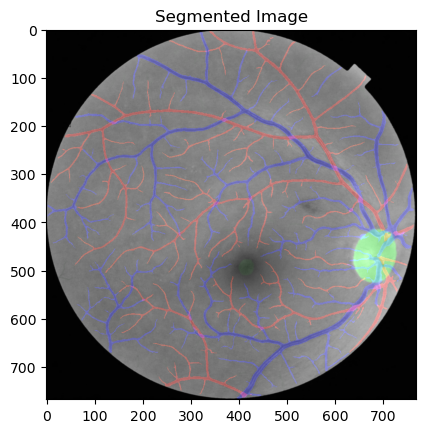

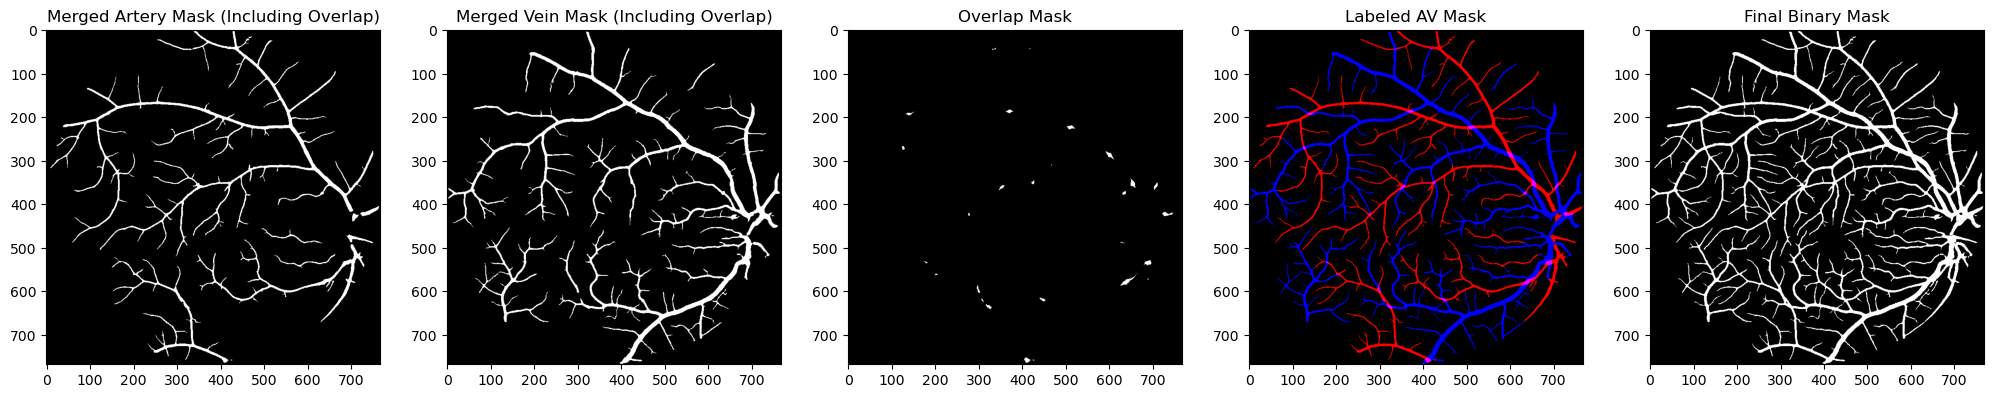

In [10]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg

# Updated function to use HSV thresholds for overlap mask
def extract_AV_overlap_masks_hsv(img, hue_min=140, hue_max=150, sat_min=50, val_min=100, val_max=255):
    # Convert image to HSV color space
    hsv_img = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2HSV)
    
    # Extract individual RGB channels for artery and vein masks
    R = img[:, :, 0]
    G = img[:, :, 1]
    B = img[:, :, 2]

    # Define artery and vein masks using RGB color differences
    diff = R - B
    artery_mask = diff > 0.1
    vein_mask = diff < -0.1

    # Create overlap mask in HSV based on best pinkish hue thresholds
    lower_bound = np.array([hue_min, sat_min, val_min])
    upper_bound = np.array([hue_max, 255, val_max])
    overlap_mask = cv2.inRange(hsv_img, lower_bound, upper_bound) > 0

    # Merge overlap with artery and vein masks
    merged_artery_mask = np.logical_or(artery_mask, overlap_mask)
    merged_vein_mask = np.logical_or(vein_mask, overlap_mask)

    # Create labeled AV mask with red for arteries and blue for veins
    height, width = artery_mask.shape
    av_mask = np.zeros((height, width, 3), dtype=np.float32)
    av_mask[merged_artery_mask, 0] = 1  # Red for arteries
    av_mask[merged_vein_mask, 2] = 1    # Blue for veins

    # Create final binary mask showing combined artery and vein areas
    bw_mask = np.logical_or(merged_artery_mask, merged_vein_mask).astype(np.float32)

    return merged_artery_mask, merged_vein_mask, overlap_mask, av_mask, bw_mask

# Load the segmented image
segmented_image_path = '/Users/chunduri/Desktop/CVD Project/Datasets/Aditya/Data/Segmented_Images/2.png'
segmented_image = mpimg.imread(segmented_image_path)

# Display the original segmented image
plt.imshow(segmented_image)
plt.title("Segmented Image")
plt.show()

# Extract artery, vein, overlap masks using the updated HSV threshold-based function
merged_artery_mask, merged_vein_mask, overlap_mask, av_mask, bw_mask = extract_AV_overlap_masks_hsv(
    segmented_image, 
    hue_min=140, 
    hue_max=150, 
    sat_min=50, 
    val_min=100, 
    val_max=255
)

# Visualize the resulting masks
fig, ax = plt.subplots(1, 5, figsize=(25, 5))
ax[0].imshow(merged_artery_mask, cmap='gray')
ax[0].set_title('Merged Artery Mask (Including Overlap)')
ax[1].imshow(merged_vein_mask, cmap='gray')
ax[1].set_title('Merged Vein Mask (Including Overlap)')
ax[2].imshow(overlap_mask, cmap='gray')
ax[2].set_title('Overlap Mask')
ax[3].imshow(av_mask)
ax[3].set_title('Labeled AV Mask')
ax[4].imshow(bw_mask, cmap='gray')
ax[4].set_title('Final Binary Mask')
plt.show()
